Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS131/fp'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This leads to the current folder
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS131/fp


In [2]:
%ls

Archive.zip  FinalProj.ipynb  kmeans-eval.ipynb  model_epoch_2.pt  model_epoch_4.pt  mod.pt
dataset/     fp.ipynb         model_epoch_1.pt   model_epoch_3.pt  model_epoch_5.pt


# CNN

First load up dataset

**NOTE: If you are running this for uncropped data, change the endswith for train_files to jpg, otherwise png**

In [35]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, train_dir, ground_dir, transform=None):
        self.train_dir = train_dir
        self.ground_dir = ground_dir
        self.train_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.jpg')], key=lambda x: int(x.split('.')[0])) # use endswith .jpg if on uncropped data, .png if on cropped
        self.ground_files = sorted([f for f in os.listdir(ground_dir) if f.endswith('.png')], key=lambda x: int(x.split('.')[0]))
        self.width, self.height = self.filter_indices()
        self.transform = transforms.Compose([
            transform,
            transforms.Resize((self.width, self.height))
        ])

    def __len__(self):
        return min(len(self.train_files), len(self.ground_files))

    def __getitem__(self, idx):

        train_img_name = self.train_files[idx]
        ground_img_name = self.ground_files[idx]

        train_img_path = os.path.join(self.train_dir, train_img_name)
        ground_img_path = os.path.join(self.ground_dir, ground_img_name)

        train_img = Image.open(train_img_path).convert('L')
        ground_img = Image.open(ground_img_path).convert('L')

        if self.transform:
            train_img = self.transform(train_img)
            ground_img = self.transform(ground_img)

        return train_img, ground_img

    def filter_indices(self):
        filtered_indices = []
        W, H = 0, 0
        for idx in range(min(len(self.train_files), len(self.ground_files))):
            train_img_name = self.train_files[idx]
            ground_img_name = self.ground_files[idx]

            train_img_path = os.path.join(self.train_dir, train_img_name)
            ground_img_path = os.path.join(self.ground_dir, ground_img_name)

            train_img = Image.open(train_img_path)
            ground_img = Image.open(ground_img_path)
            W, H = max(W, train_img.size[0], ground_img.size[0]), max(H, train_img.size[1], ground_img.size[1])

        return W,H

train_transform = transforms.Compose([
    transforms.ToTensor()
])
'''
train_dir = "./dataset/Training_Images/"
ground_dir = "./dataset/Ground_Truth/"
dataset = CustomDataset(train_dir, ground_dir, train_transform)
sample_train_img, sample_ground_img = dataset[1]
'''

'\ntrain_dir = "./dataset/Training_Images/"\nground_dir = "./dataset/Ground_Truth/"\ndataset = CustomDataset(train_dir, ground_dir, train_transform)\nsample_train_img, sample_ground_img = dataset[1]\n'

In [6]:
# Define the size of the test set
test_size = int(0.2 * len(dataset))  # 20% of the dataset for testing
print(sample_train_img.shape)

torch.Size([1, 1500, 1500])


Now to create the model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HumanSegmentationModel(nn.Module):
    def __init__(self, input_channels=3):
        super(HumanSegmentationModel, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=4)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Decoder
        x = F.relu(self.upconv1(x))
        x = F.relu(self.conv3(x))
        return x

model = HumanSegmentationModel(input_channels=1)
print(model)

HumanSegmentationModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(4, 4))
  (conv3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [59]:
import numpy as np

sample_train_img, sample_ground_img = dataset[1]

img = sample_train_img
model.load_state_dict(torch.load('./model_epoch_1.pt'))
model.eval()

with torch.no_grad():
  outputs = model(img)
  print(outputs)
  # 0.275
  predictions = (outputs).float() # (outputs > 0.5).float()
  numpy_image = predictions.numpy()
  numpy_image = numpy_image**5
  numpy_image /= np.max(numpy_image)

  numpy_image = numpy_image > 0.5
  print(numpy_image)
  numpy_image = numpy_image.reshape(1500,1500,1)

  scaled_image = numpy_image * 255
  bw_image = scaled_image.astype(np.uint8)


tensor([[[0.2374, 0.2358, 0.2580,  ..., 0.2089, 0.2232, 0.1274],
         [0.2678, 0.2930, 0.2979,  ..., 0.2549, 0.2589, 0.1432],
         [0.2740, 0.2884, 0.2787,  ..., 0.2448, 0.2397, 0.1442],
         ...,
         [0.2765, 0.3016, 0.3108,  ..., 0.3189, 0.3302, 0.1870],
         [0.2917, 0.3028, 0.3002,  ..., 0.3232, 0.3253, 0.1807],
         [0.2117, 0.2173, 0.2143,  ..., 0.2308, 0.2292, 0.1422]]])
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False  True False]
  [False False False ...  True  True False]
  [False False False ... False False False]]]


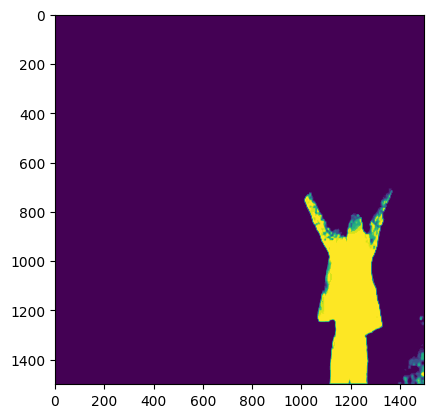

In [60]:
import matplotlib.pyplot as plt
plt.imshow(bw_image)
plt.show()

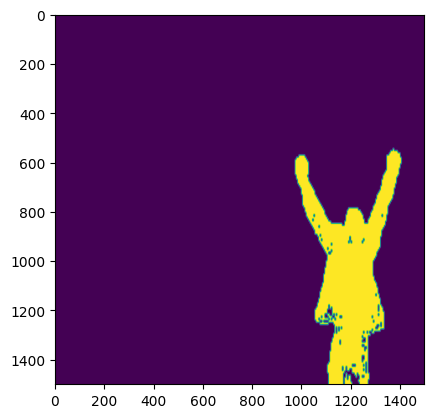

In [61]:
g = sample_ground_img.float().numpy()
g = g.reshape((1500,1500,1))
plt.imshow(g)

Training Loop

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define paths to train directory and ground truth directory
train_dir = "./dataset/Training_Images/"
ground_dir = "./dataset/Ground_Truth/"
dataset = CustomDataset(train_dir, ground_dir, train_transform)
test_size = int(0.2 * len(dataset))


train_dataset, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [6]:
class CustomLoss(nn.Module):
    """
    Loss module that penalizes false negatives as to promote the model to not trivially classify everything as background
    """
    def __init__(self, weight_fn=1.0):
        super(CustomLoss, self).__init__()
        self.weight_fn = weight_fn

    def forward(self, outputs, labels):
        bce_loss = nn.BCELoss()(outputs, labels)
        fn = torch.sum((outputs <= 0.5) & (labels == 1)).float()
        loss = bce_loss + self.weight_fn * fn

        return loss

In [14]:
model = HumanSegmentationModel(input_channels=1)
criterion = CustomLoss(weight_fn=10.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    model_file = os.path.join(os.getcwd(), f'model_epoch_{epoch + 1}.pt')
    torch.save(model.state_dict(), model_file)

  0%|          | 0/58 [00:04<?, ?it/s]


KeyboardInterrupt: 

# **Testing Loop**

In [15]:

%ls

Archive.zip  FinalProj.ipynb  kmeans-eval.ipynb  model_epoch_2.pt  model_epoch_4.pt  mod.pt
dataset/     fp.ipynb         model_epoch_1.pt   model_epoch_3.pt  model_epoch_5.pt


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define paths to train directory and ground truth directory
train_dir = "./dataset/Training_Images_Cropped/"
ground_dir = "./dataset/Ground_Truth_Cropped/"
dataset = CustomDataset(train_dir, ground_dir, train_transform)
test_size = int(0.2 * len(dataset))


train_dataset, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [25]:
import numpy as np

# Testing loop
model.load_state_dict(torch.load('./model_epoch_1.pt'))
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        # predictions = (outputs > 0.5).float()

        # New outputs
        predictions = (outputs).float() # (outputs > 0.5).float()
        predictions = predictions.numpy()
        predictions = predictions**7
        predictions /= np.max(predictions)
        predictions = predictions > 0.5
        predictions = torch.from_numpy(predictions)

        all_labels.append(labels.view(-1).numpy())
        all_predictions.append(predictions.view(-1).numpy())
all_labels = [int(item) for sublist in all_labels for item in sublist]
all_predictions = [int(item) for sublist in all_predictions for item in sublist]
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7404


In [27]:
# get the accuracy
accuracy = np.sum(np.equal(all_predictions, all_labels)) / len(all_predictions)
# get the precision
precision = np.sum(np.logical_and(all_predictions, all_labels)) / np.sum(all_predictions)
# get the recall
recall = np.sum(np.logical_and(all_predictions, all_labels)) / np.sum(all_labels)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
# get the F1 score
F1 = 2 * precision * recall / (precision + recall)
print('F1:', F1)

Accuracy: 0.7404451417624521
Precision: 0.5682629542867933
Recall: 0.05193941991878057
F1: 0.09517941057479849


In [16]:
print(sum(all_predictions))

1963510


# TESTING ON THE CURATED

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define paths to train directory and ground truth directory
train_dir = "./dataset/Training_Curated/"
ground_dir = "./dataset/Ground_Curated/"
dataset = CustomDataset(train_dir, ground_dir, train_transform)
test_dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Testing loop
model.load_state_dict(torch.load('./model_epoch_1.pt'))
model.eval()
all_labels = []
all_predictions = []
idx = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        idx += 1
        outputs = model(inputs)
        # predictions = (outputs > 0.5).float()

        # New outputs
        predictions = (outputs).float() # (outputs > 0.5).float()
        predictions = predictions.numpy()
        predictions = predictions**7
        predictions /= np.max(predictions)
        predictions = predictions > 0.5
        predictions = torch.from_numpy(predictions)

        all_labels.append(labels.view(-1).numpy())
        all_predictions.append(predictions.view(-1).numpy())
print(len(all_labels), len(all_predictions))
all_labels = [int(item) for sublist in all_labels for item in sublist]
all_predictions = [int(item) for sublist in all_predictions for item in sublist]
all_labels = all_labels[:len(all_predictions)]
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

1 1
Accuracy: 0.6153


In [47]:
# get the accuracy
accuracy = np.sum(np.equal(all_predictions, all_labels)) / len(all_predictions)
# get the precision
precision = np.sum(np.logical_and(all_predictions, all_labels)) / np.sum(all_predictions)
# get the recall
recall = np.sum(np.logical_and(all_predictions, all_labels)) / np.sum(all_labels)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
# get the F1 score
F1 = 2 * precision * recall / (precision + recall)
print('F1:', F1)

Accuracy: 0.6152699058512827
Precision: 0.6309481216457961
Recall: 0.02431675234639079
F1: 0.046828724768983164
